In [3]:
#import av
import numpy as np
#import trackpy
#import matplotlib #for making plots inside the notebook 
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from itertools import chain
from skimage import measure
from skimage.filters import threshold_isodata, threshold_yen
from glob import glob

"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [4]:
#filename = input("What is the path to the file?\n")
filename = "C:/Users/Tchakamau/Desktop/Soft Matter/tchakamau/New_setup/45681_10Vpp_25.avi"

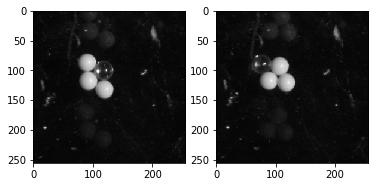

In [5]:
Vid = skvideo.io.vread(filename)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(Vid[0]) # first fame of video
ax[1].imshow(Vid[-1]) #last frame of video


(698, 256, 256)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Text(0.5, 1.0, 'Truncated histogram')

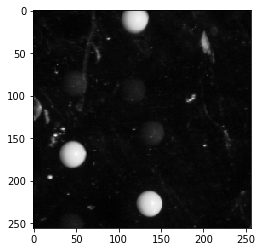

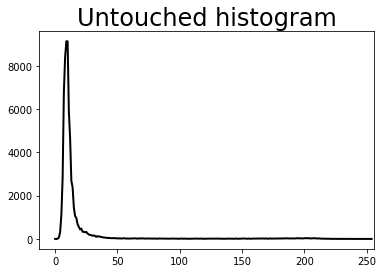

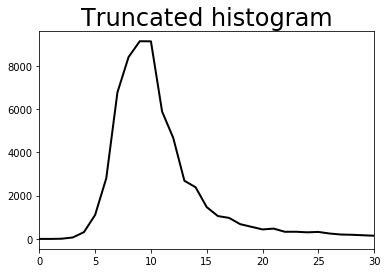

In [6]:
"""Testing that the frames loaded correctly. They should be 2D matrices, in order to be used by sci-kit image programs. 
Shape of the frame colletion should hve 3 values, and shape of each frame should have 2 values.
Checking that a frame is legible as an image by displaying it."""
green = Vid[:, :, :, 2]
print(green.shape)
plt.imshow(green[500], cmap='Greys_r')

# Histogram
fig, ax1 = plt.subplots()
values, bins = np.histogram(green[500],
                            bins=np.arange(256))

ax1.plot(bins[:-1], values, lw=2, c='k')
ax1.set_xlim(xmax=256)
ax1.set_title('Untouched histogram', fontsize=24)


fig, ax1 = plt.subplots()
values, bins = np.histogram(green[500],
                            bins=np.arange(256))

ax1.plot(bins[:-1], values, lw=2, c='k')
ax1.set_xlim(xmax=30, xmin = 0)
ax1.set_title('Truncated histogram', fontsize=24)

In [5]:
"""
First, we'll binarize the whole image for each frame
then find connected components and filter out all but the largest
then, for each frame, see if the largest CC has the right no. of particles (by area sounds good)
if not, then delete that frame from the list

With the resulting list, binarize agian with a diffeent threshold, to eep the transparent one out,
find connected compoents again and take the largest, 
and this time for each frame, see what shape it contains 
    keep a list of frame shapes, 
    including a shape that represents transitioning states, e.g. none-of-the-above.
"""

"\nFirst, we'll binarize the whole image for each frame\nthen find connected components and filter out all but the largest\nthen, for each frame, see if the largest CC has the right no. of particles (by area sounds good)\nif not, then delete that frame from the list\n\nWith the resulting list, binarize agian with a diffeent threshold, to eep the transparent one out,\nfind connected compoents again and take the largest, \nand this time for each frame, see what shape it contains \n    keep a list of frame shapes, \n    including a shape that represents transitioning states, e.g. none-of-the-above.\n"

In [6]:
"""All the work below is done on a single frame 
    Will be applied over all frames eventually"""

'All the work below is done on a single frame \n    Will be applied over all frames eventually'

In [7]:
"""Pt1. 
    Binarize image, 
    and then find conected components
    and then filter those for only the largest
"""

'Pt1. \n    Binarize image, \n    and then find conected components\n    and then filter those for only the largest\n'

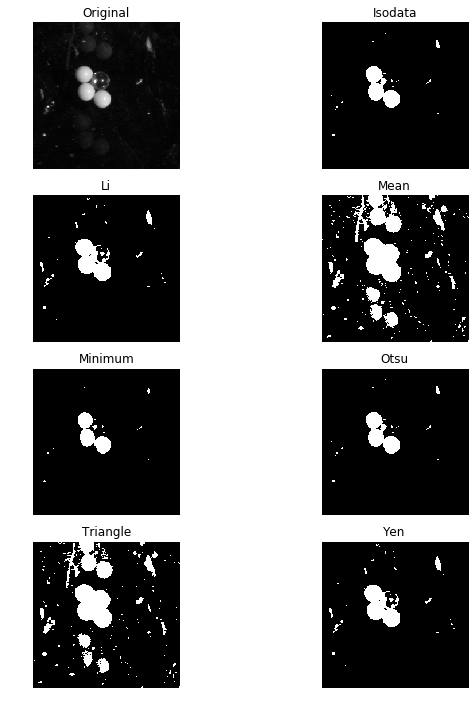

In [8]:
"Tryign built-in thresholds for separating image and background"
from skimage.filters import try_all_threshold
trigger_frame = 26894 
img = green[trigger_frame - 25000] #example image (tf + 9606 is an error!)

fig, ax = try_all_threshold(img, figsize=(10, 10), verbose=False)
#plt.show()


In [9]:
"""Pt2. 
    Filter shapes with wrong number of balls 
        Do using area maybe
"""

'Pt2. \n    Filter shapes with wrong number of balls \n        Do using area maybe\n'

In [10]:
"""LARGER RANGES FROM VIDEO"""
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, indes):
    # returns a new list, different from the orginal
    m_lab = measure.label
    m_rop = measure.regionprops
    fll = len(framelist)
    thresh_imgs = [frame > threshold_yen(frame) for frame in framelist]
    imgs_labelled = [m_lab(i) for i in thresh_imgs]
    properties_lists = list(map(lambda im: m_rop(im, coordinates = 'rc'), imgs_labelled))
    biggest_rs = [max(prop_list, key = attrgetter('area')) for prop_list in properties_lists]
    
    area_threshold = 1880   # must have enough particles
    convex_threshold = 2500   # convex hull area (> 2500 filtered)  # particles must be in parallelogram
    minor_threshold = 40 # minor_axis length (< filterd) # particles must be in parallelogram
        
    f_indices = [index for index in range(fll) if (biggest_rs[index].filled_area > area_threshold
                 and biggest_rs[index].minor_axis_length > minor_threshold 
                 and biggest_rs[index].convex_area < convex_threshold)] # indices
    

    return [[framelist[i], indes[i]] for i in f_indices]
trigger_frame = 26894 
phantom_frames = {"b_r" : list(range(10950, 10772, -1)),
                  "t_r" : list(range(17866, 17507, -1)), "t_l" : list(range(17000, 16289, -1)),
                  "b_m" : list(range(20947, 19727, -2)), "b_l" : list(range(26399, 25819, -1)),
                 "broken" : list(chain(range(11274, 11202, -1), range(21520, 21162, -2))),
                 "odd_s" : list(chain(range(21066, 21036, -1), range(18071, 18052, -1), range(17948, 17910, -1),
                                    range(15671, 15659, -1) ))}
b_r_frames = []
brvals  = []
b_l_frames = []
blvals = []
t_r_frames = []
trvals = []
t_l_frames = []
tlvals = []
b_m_frames = []
bmvals = []
broken_frames = []
brokenvals = []
odd_s_frames = []
oddsvals = []

framesets = [b_r_frames, b_l_frames, t_r_frames, t_l_frames, b_m_frames, broken_frames, odd_s_frames]
frametypevals = [brvals, blvals, trvals, tlvals, bmvals, brokenvals, oddsvals]
framesetnames = ["b_r", "b_l", "t_r", "t_l", "b_m", "broken", "odd_s"]

for i in range(len(framesetnames)):
    frametypevals[i].extend(phantom_frames.get(framesetnames[i]))
    typevals = frametypevals[i]
    framesets[i].extend(total_threshold_filter(green[[trigger_frame - x for x in typevals]], typevals))
    #print(framesets[i])
    
    orig = len(typevals)
    filtrate = len(framesets[i])
    print(framesetnames[i])
    print("original: ", orig)
    #print("filtrate: ", filtrate)
    print("pass ratio: ", filtrate*100/orig)
    print("\n")
 


b_r
original:  178
pass ratio:  93.25842696629213


b_l
original:  580
pass ratio:  79.48275862068965


t_r
original:  359
pass ratio:  76.04456824512535


t_l
original:  711
pass ratio:  55.9774964838256


b_m
original:  610
pass ratio:  78.19672131147541


broken
original:  251
pass ratio:  0.0


odd_s
original:  99
pass ratio:  29.292929292929294




In [11]:
"Retreving properties for test frames with 1st hreshold"

# applies yen filter to test frames, and gets properties
# returns list of the properties
#  fraemelist is a frame and a frame index
def opaque_threshold_properties(framelist):
    filtrate = []
    for framepair in framelist:
        frame = framepair[0] 
        thresh_img = frame > threshold_yen(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = properties_list[0] 
        
        for region in properties_list:
            if region.area > biggest_r.area:
                biggest_r = region
            else:
                pass
            
        filtrate.append([biggest_r, framepair[1], img_labelled])#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


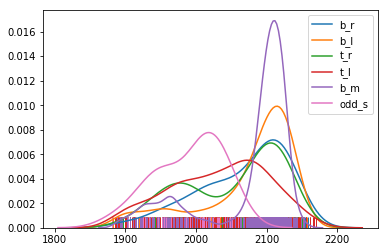

In [12]:
"""Determining the area of the object"""
for j in range(0, len(framesets)):
    i_props = opaque_threshold_properties(framesets[j])
    #print(framesetnames[j] + " filled_areas :", [[i[0].filled_area, i[1]] for i in i_props])
    #y = [[i[0].filled_area, i[1]] for i in i_props]
    x = [i[0].filled_area for i in i_props]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

#with 5 spheres, area is over 1800, even with one bent out of plane; with 4 spheres it's  below 1700

127


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IndexError: list index out of range

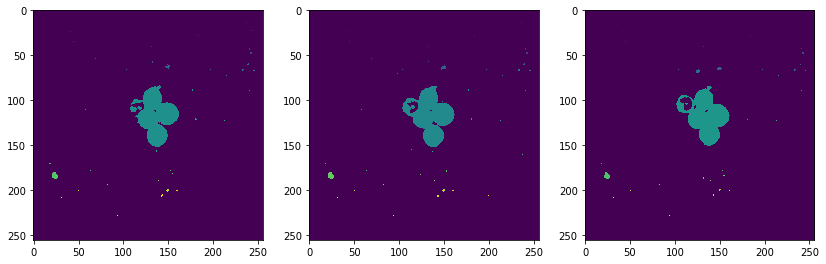

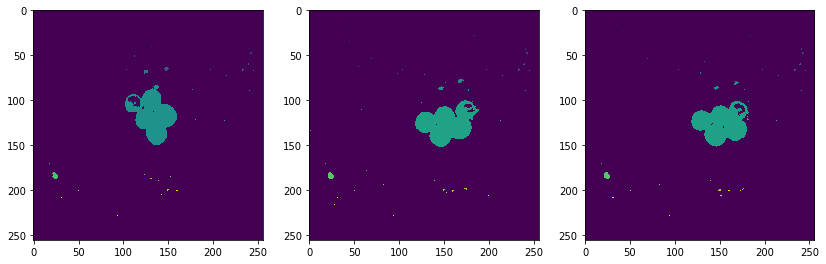

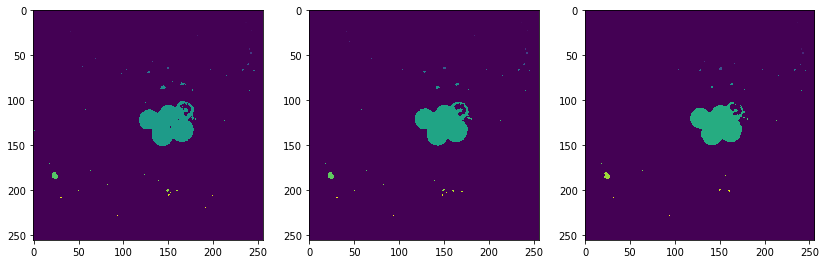

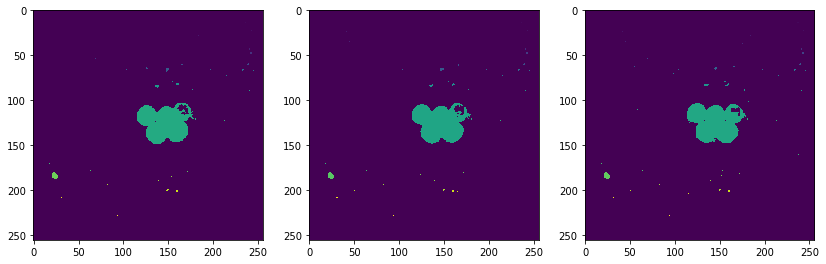

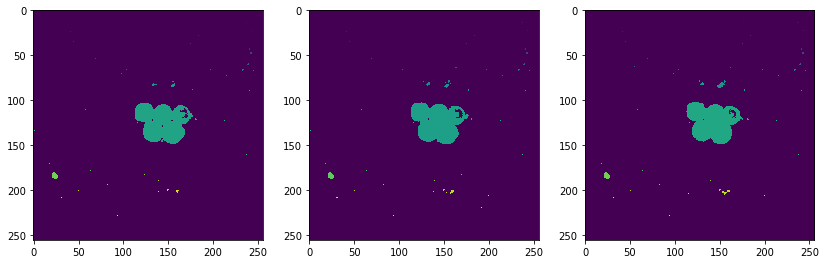

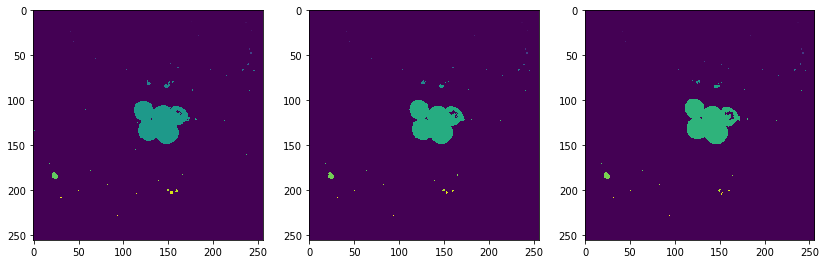

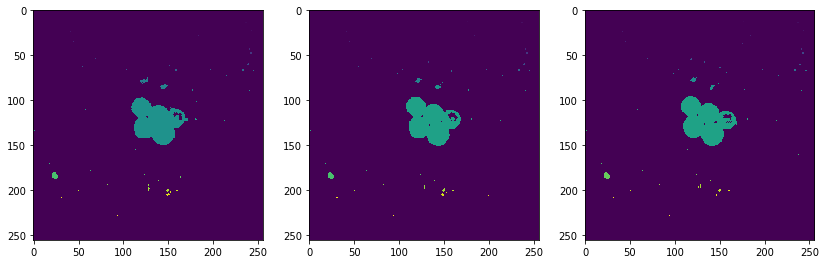

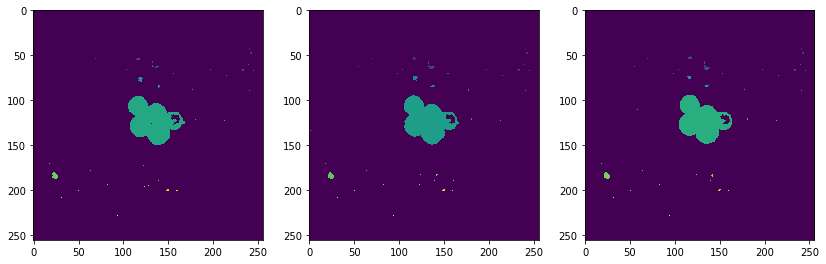

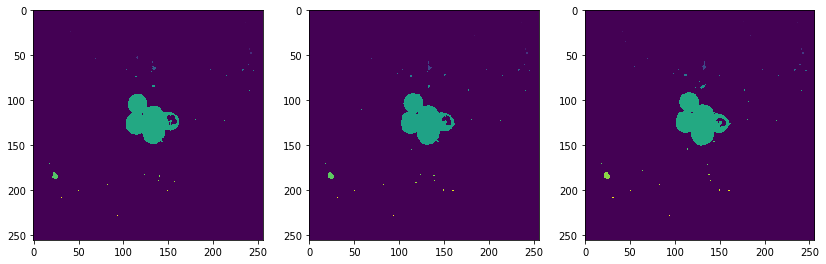

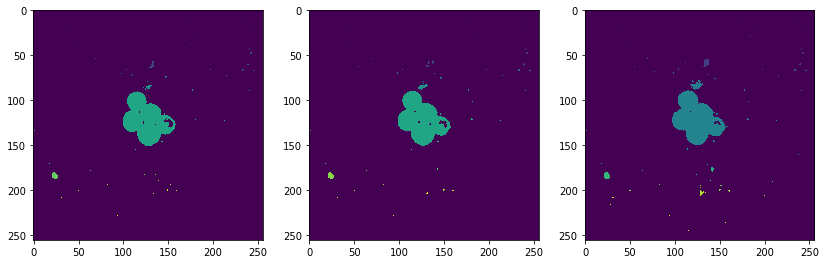

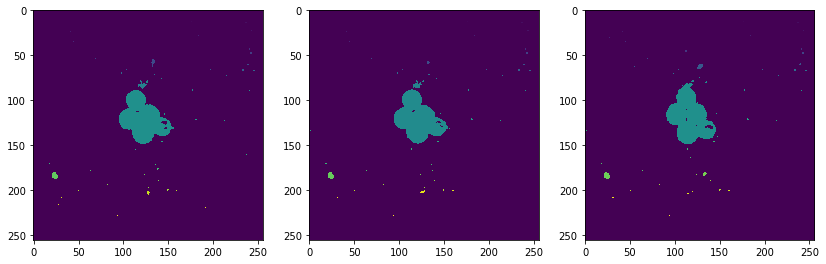

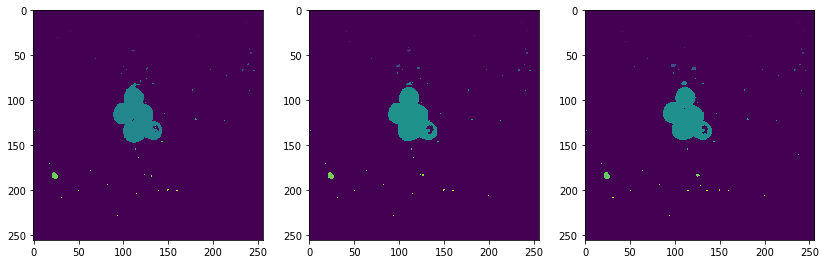

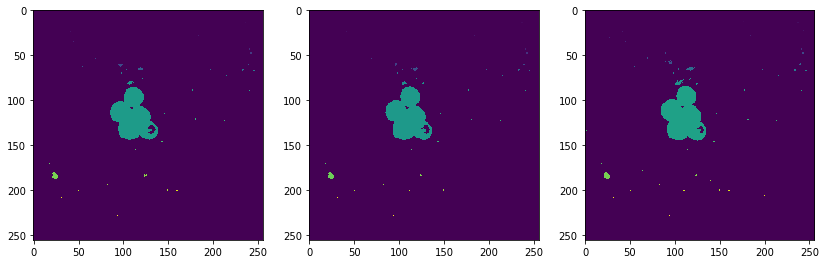

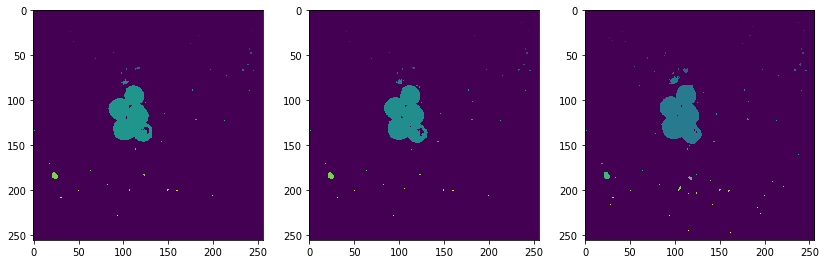

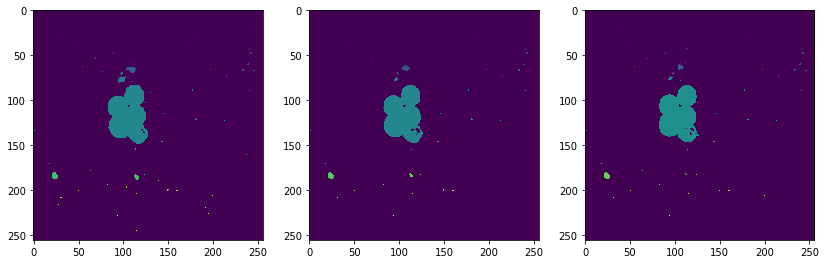

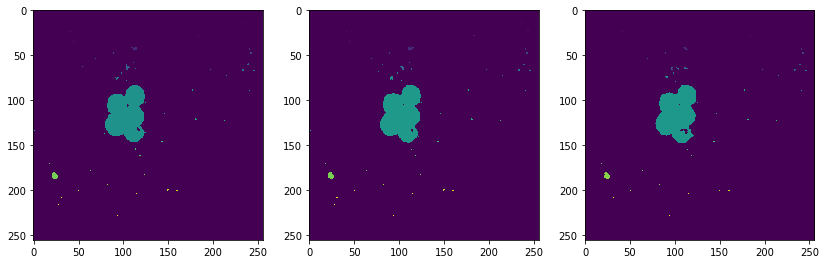

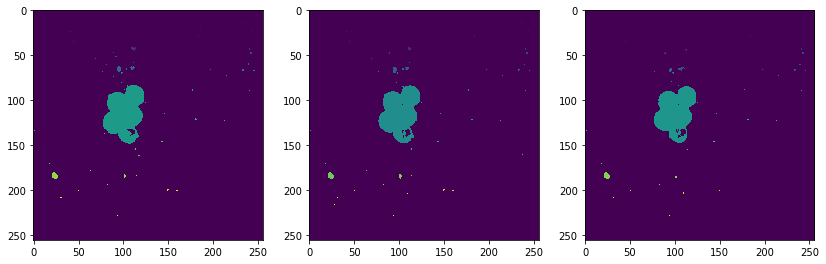

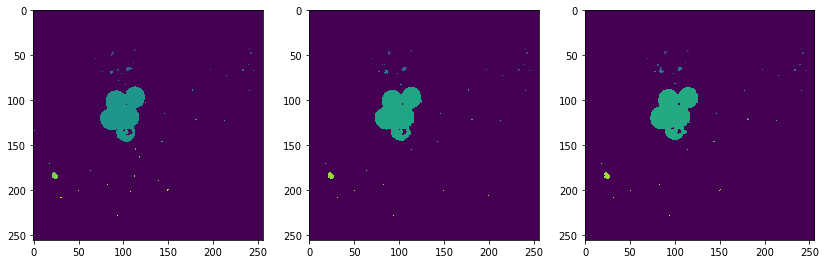

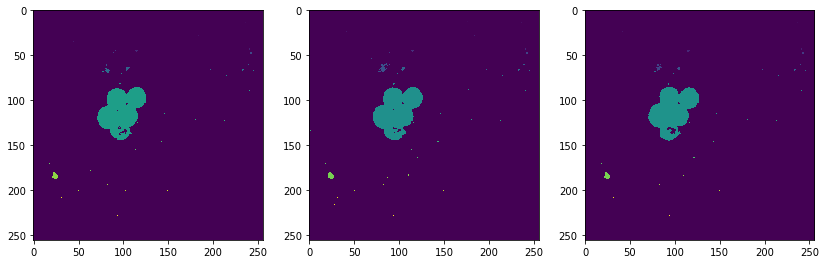

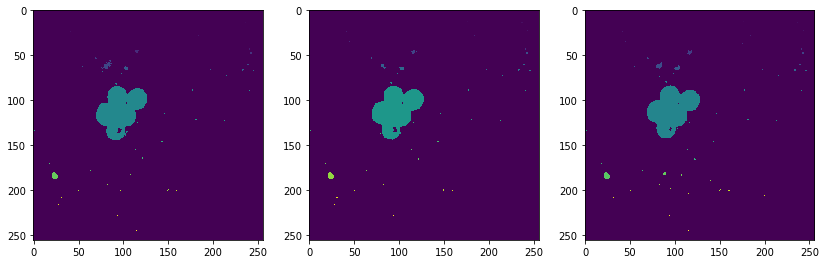

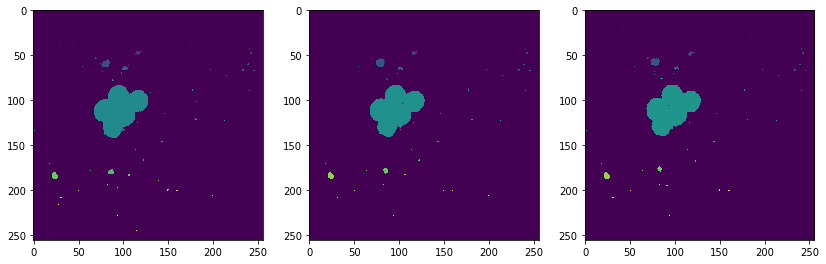

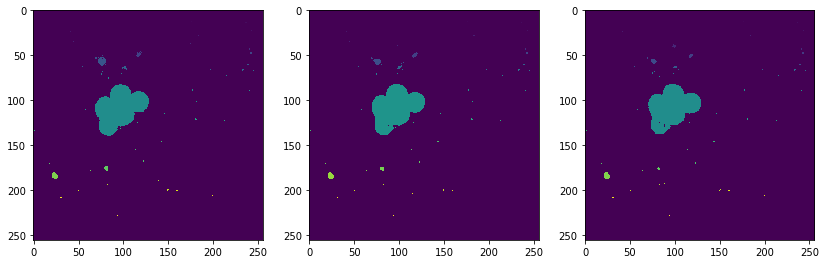

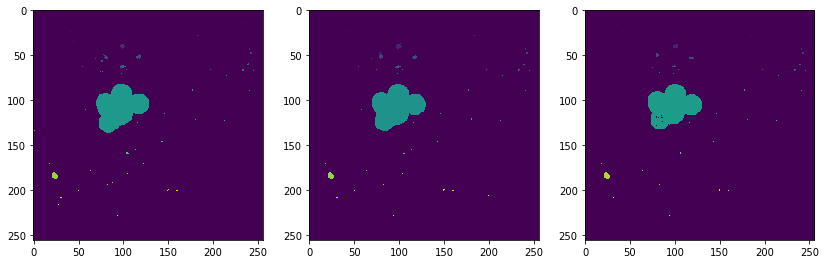

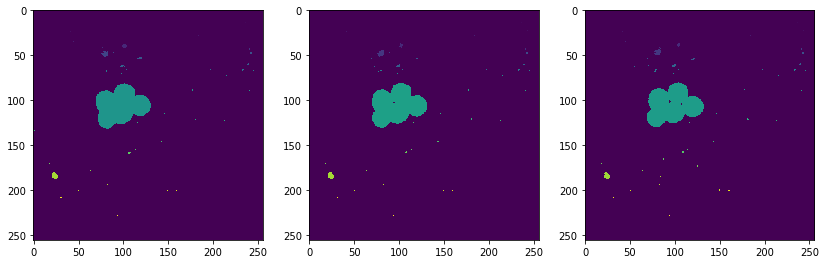

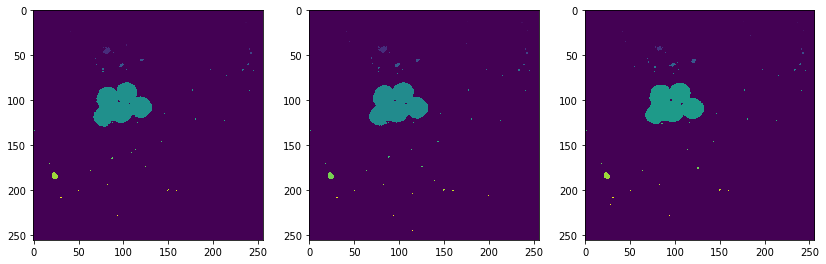

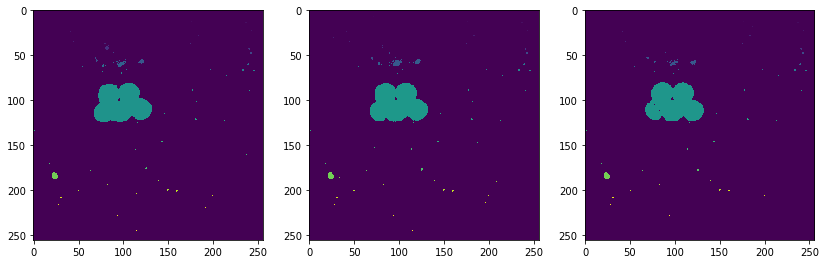

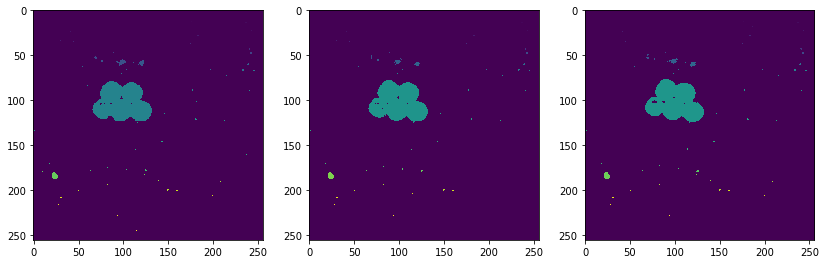

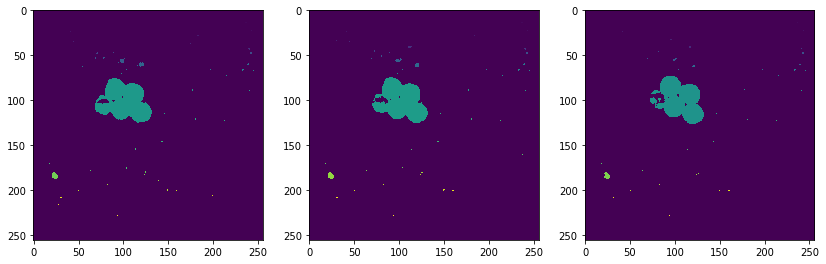

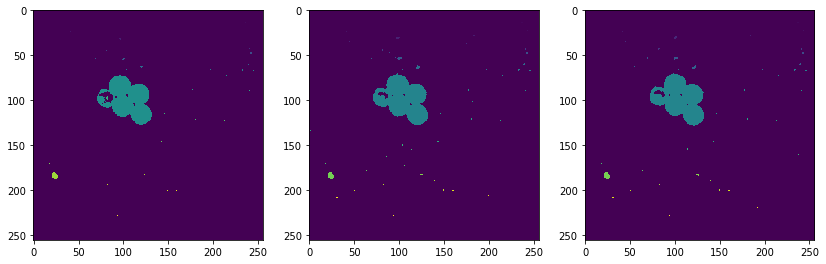

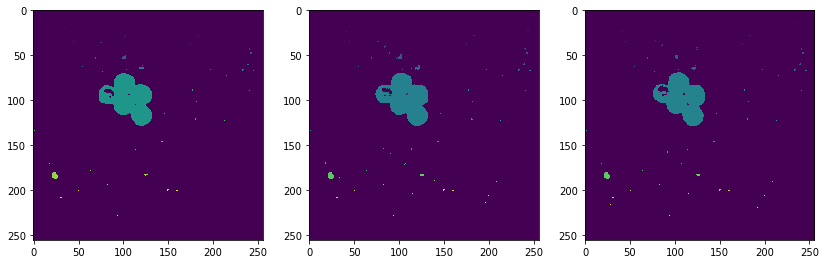

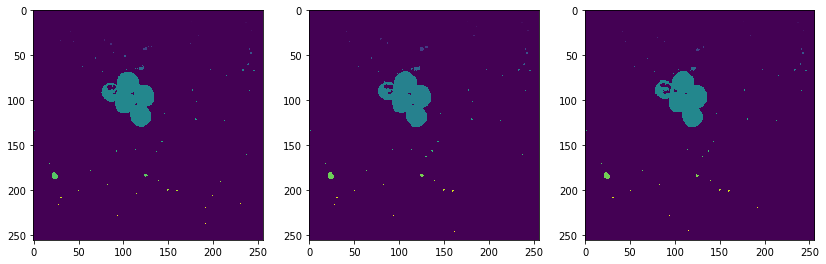

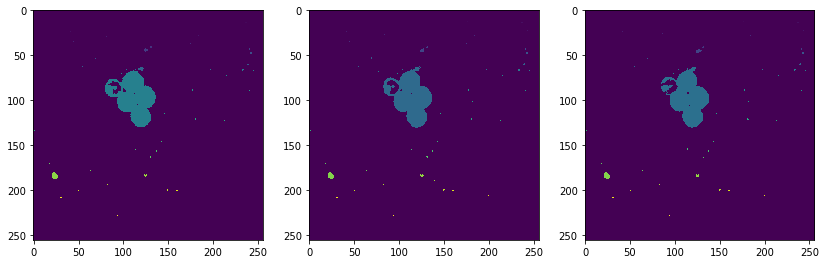

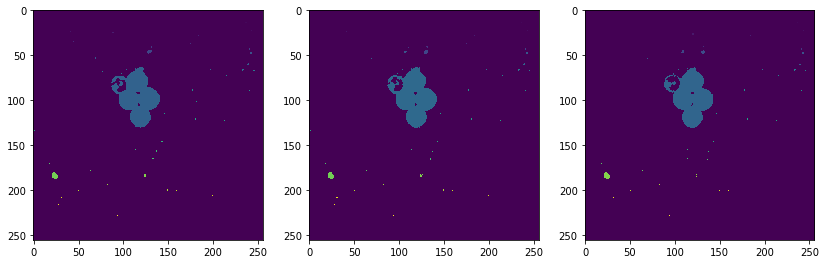

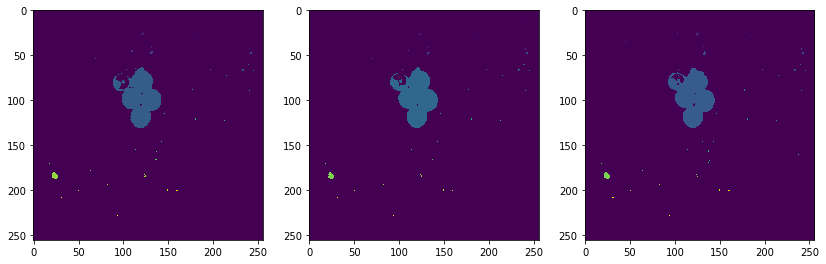

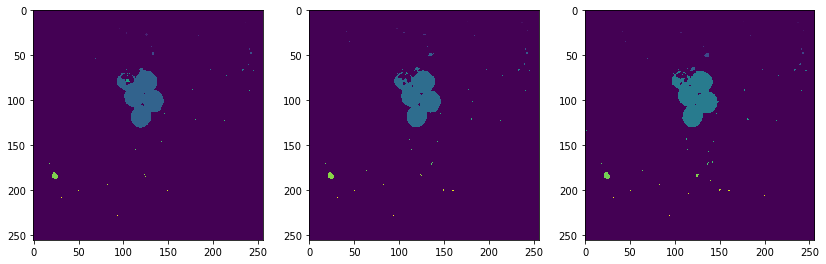

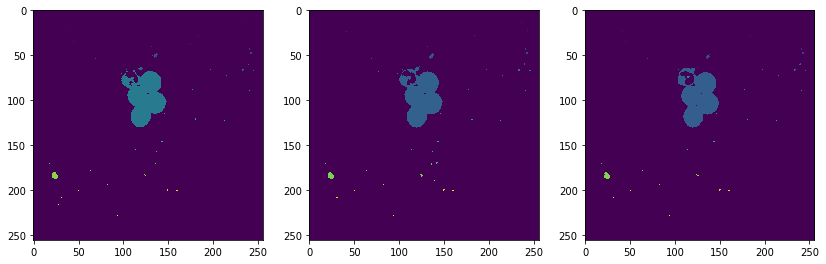

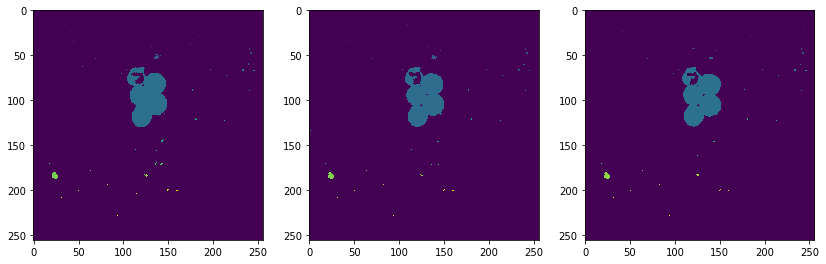

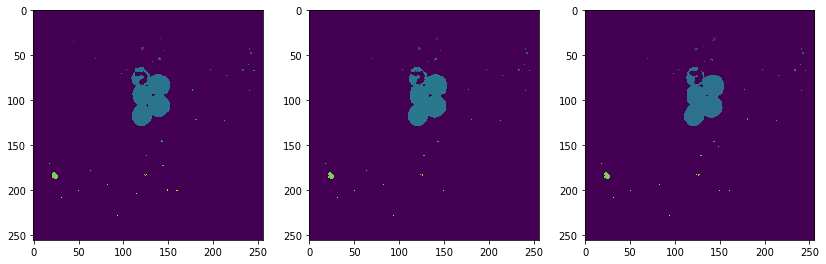

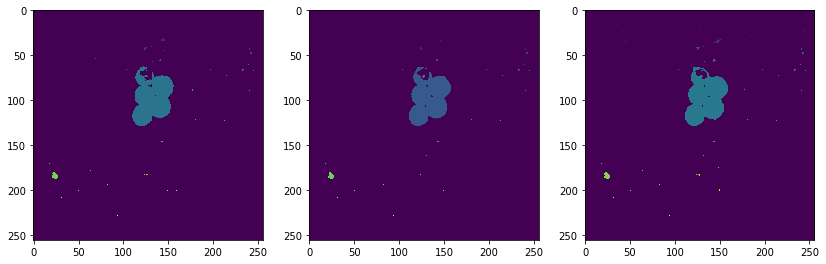

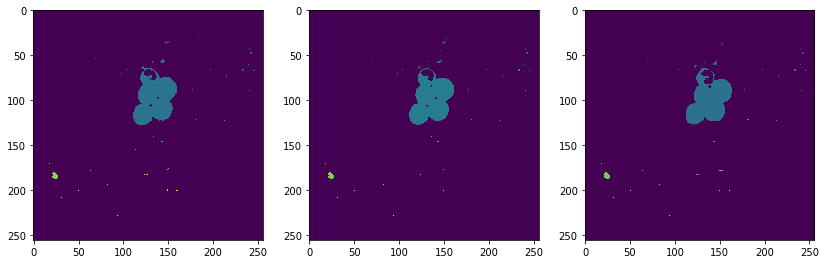

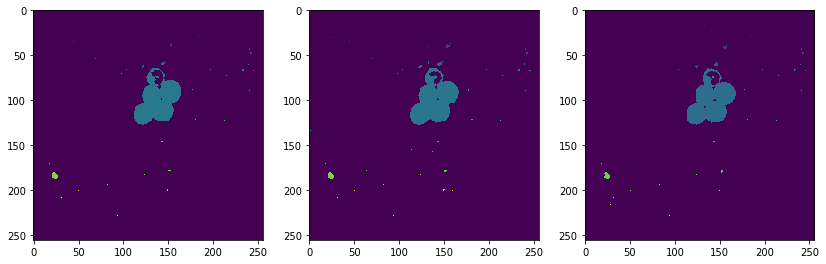

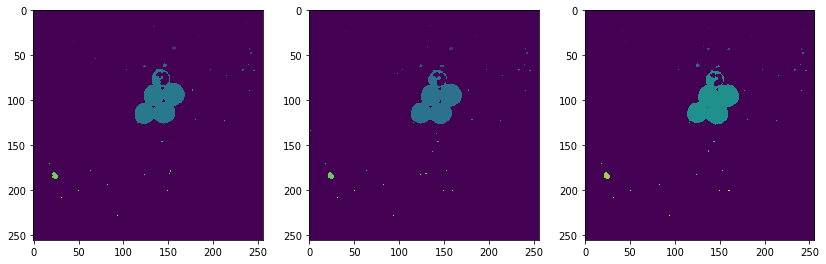

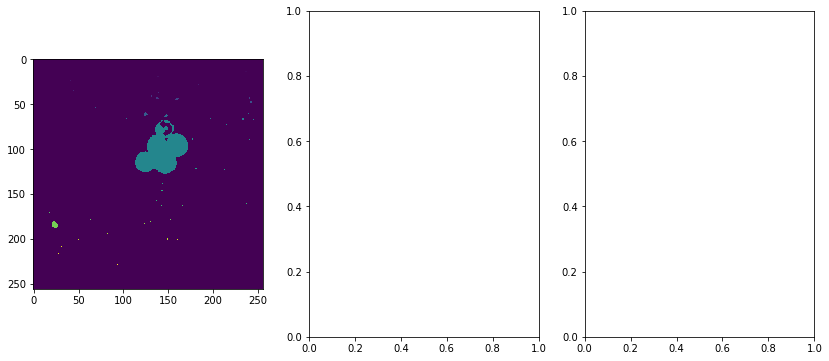

In [13]:
"""sorting out tricky region"""
ran = list(range(25103, 24458, -1))
#print (len(ran))
#print(ran)
fps = [[green[trigger_frame - i], i] for i in ran]
i_props = opaque_threshold_properties(fps)
too_big = [[i[0].filled_area, i[1], i[2]] for i in i_props if (i[0].filled_area > 1880 and i[0].minor_axis_length >40 
                                                               and i[0].convex_area < 2500
                                                              )]
#print("tricky "+ " filled_areas :", too_big)
print(len(too_big))
r = 50
c = 3
for i in range(r):
    fig, ax = plt.subplots(ncols = c, figsize = (14, 6))
    for k in range(c):
        ax[k].imshow(too_big[i*c + k][2])
        

"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

In [14]:
"""Srepaating out odd_shaped frames)"""
for i in range(0, len(framesets)):
    i_props = opaque_threshold_properties(framesets[i])
    print(framesetnames[i] + " inertia tensors: ", [[i[0].inertia_tensor[0, 0] + i[0].inertia_tensor[1,1], i[1]] for i in i_props])
print("\n\n")

for i in range(0, len(framesets)):
    i_props = opaque_threshold_properties(framesets[i])
    print(framesetnames[i] + " convex_areas : ", [[i[0].convex_area, i[1]] for i in i_props])
print("\n\n")

for i in range(0, len(framesets)):
    i_props = opaque_threshold_properties(framesets[i])
    print(framesetnames[i] + " minor_axis_length : ", [[i[0].minor_axis_length, i[1]] for i in i_props])
print("\n\n")



# most oddly shaped frames have elongated shapes, and the mnor axis length is below 40, except for one (of one partcular type)
# where the pixels for a 'T' shape; this, while more rounded, has a huge convex hull. All frames wth convex hull area 
# over 2500 (very conservatve estimate) areoddly shaped (transition frames). 
# Together the criteria select for frames not in transition.
#16766 is misclassified, but it isvery like a normally shaped t_l on most measures, so maybe it should be counted as one for this program

b_r inertia tensors:  [[372.13108725350344, 10950], [366.0636887218685, 10949], [367.1460632307264, 10948], [372.28171814851896, 10947], [377.02464870015194, 10946], [378.2470466077573, 10945], [376.4829149072456, 10944], [373.9158125311224, 10943], [375.61180051266354, 10942], [370.1769004406357, 10941], [365.40167253727236, 10940], [362.95211395202534, 10939], [361.7594423973821, 10938], [364.1220506230976, 10937], [367.7343229663222, 10936], [370.7898340727031, 10935], [374.8102424041671, 10934], [372.016084434198, 10933], [368.25028795276125, 10932], [367.41060162406063, 10931], [369.53341187912565, 10930], [373.3975829603311, 10929], [381.0539199683484, 10928], [382.8504238947033, 10927], [384.1971508424601, 10926], [379.6529554146065, 10925], [385.40862782803435, 10924], [369.8174140393838, 10923], [371.2860421363531, 10922], [363.87862610714524, 10921], [362.63610208073965, 10920], [383.26401679918905, 10919], [379.39387789876935, 10918], [397.4978354998349, 10917], [402.2148687

t_r inertia tensors:  [[426.78408845079554, 17866], [427.65683075966865, 17865], [425.2610790994745, 17864], [420.59236459510277, 17861], [420.26366123473093, 17860], [429.76461690916904, 17859], [423.07665689652305, 17858], [419.56213883487794, 17857], [417.89996034405704, 17856], [417.54479479211244, 17855], [416.20569841073007, 17854], [419.3882780601398, 17853], [419.6798160378771, 17852], [421.56429033151267, 17851], [425.7201937602845, 17850], [429.8907324733107, 17849], [427.9021836424127, 17848], [429.0192074896571, 17847], [425.92360399746235, 17846], [428.42527660720214, 17845], [422.9046291901252, 17844], [427.15869449985576, 17843], [427.9951644278251, 17842], [424.70082249154194, 17841], [419.88549397545523, 17840], [421.99660778704526, 17839], [421.4610845001424, 17838], [417.3764610992992, 17837], [418.9816090146536, 17836], [421.37206798045906, 17835], [420.1844168756139, 17834], [423.80632646046024, 17833], [423.2683329862557, 17832], [428.36709512539153, 17830], [425.

b_m inertia tensors:  [[409.6016838827868, 20947], [412.47181709323206, 20945], [400.73196893577494, 20943], [396.4438194476462, 20941], [410.8253283061049, 20939], [408.5114834925557, 20937], [402.5024182739934, 20935], [399.88881589177527, 20933], [408.3830730161669, 20931], [412.21309082653954, 20929], [400.08894373431656, 20927], [402.3090680282776, 20925], [411.02099195401604, 20923], [407.974646579744, 20921], [402.76718554344797, 20919], [400.2684901427322, 20917], [408.41019314936545, 20915], [413.8885145590766, 20913], [407.68445974439805, 20911], [403.83459536513203, 20909], [407.84507062193796, 20907], [410.9195500241949, 20905], [406.1385788864689, 20903], [404.91912135504356, 20901], [410.4620609097586, 20899], [418.56796417631233, 20897], [407.509975191772, 20895], [401.4184506013169, 20893], [407.8514040305772, 20891], [411.5369679161847, 20889], [406.3813804771491, 20887], [403.3450755830279, 20885], [411.47654751174264, 20883], [414.48979552153764, 20881], [405.3207749

b_r convex_areas :  [[2296, 10950], [2257, 10949], [2264, 10948], [2283, 10947], [2288, 10946], [2315, 10945], [2317, 10944], [2298, 10943], [2312, 10942], [2269, 10941], [2240, 10940], [2225, 10939], [2218, 10938], [2213, 10937], [2235, 10936], [2265, 10935], [2286, 10934], [2291, 10933], [2284, 10932], [2269, 10931], [2280, 10930], [2302, 10929], [2361, 10928], [2386, 10927], [2331, 10926], [2336, 10925], [2364, 10924], [2347, 10923], [2339, 10922], [2339, 10921], [2290, 10920], [2478, 10919], [2384, 10918], [2482, 10917], [2476, 10916], [2412, 10915], [2395, 10914], [2347, 10913], [2386, 10912], [2250, 10911], [2291, 10910], [2330, 10909], [2337, 10908], [2447, 10907], [2415, 10906], [2453, 10905], [2486, 10904], [2451, 10903], [2442, 10902], [2281, 10901], [2364, 10900], [2360, 10899], [2391, 10898], [2454, 10897], [2459, 10896], [2427, 10895], [2429, 10894], [2469, 10893], [2346, 10892], [2347, 10891], [2392, 10890], [2368, 10889], [2419, 10888], [2341, 10887], [2350, 10886], [235

t_r convex_areas :  [[2463, 17866], [2413, 17865], [2441, 17864], [2407, 17861], [2386, 17860], [2474, 17859], [2460, 17858], [2430, 17857], [2404, 17856], [2442, 17855], [2415, 17854], [2454, 17853], [2459, 17852], [2425, 17851], [2478, 17850], [2467, 17849], [2397, 17848], [2456, 17847], [2432, 17846], [2431, 17845], [2384, 17844], [2436, 17843], [2454, 17842], [2452, 17841], [2452, 17840], [2462, 17839], [2453, 17838], [2415, 17837], [2453, 17836], [2473, 17835], [2411, 17834], [2454, 17833], [2420, 17832], [2453, 17830], [2475, 17829], [2445, 17828], [2484, 17827], [2472, 17826], [2486, 17825], [2461, 17824], [2469, 17822], [2443, 17821], [2492, 17820], [2447, 17819], [2457, 17817], [2467, 17816], [2435, 17810], [2446, 17809], [2469, 17808], [2493, 17807], [2497, 17803], [2386, 17792], [2389, 17791], [2384, 17790], [2383, 17789], [2388, 17788], [2416, 17787], [2402, 17786], [2453, 17785], [2419, 17784], [2387, 17781], [2380, 17779], [2466, 17776], [2467, 17773], [2480, 17772], [245

b_m convex_areas :  [[2443, 20947], [2404, 20945], [2355, 20943], [2325, 20941], [2394, 20939], [2429, 20937], [2374, 20935], [2386, 20933], [2469, 20931], [2392, 20929], [2341, 20927], [2351, 20925], [2423, 20923], [2437, 20921], [2379, 20919], [2412, 20917], [2438, 20915], [2411, 20913], [2368, 20911], [2375, 20909], [2418, 20907], [2437, 20905], [2423, 20903], [2421, 20901], [2435, 20899], [2450, 20897], [2411, 20895], [2384, 20893], [2418, 20891], [2452, 20889], [2428, 20887], [2420, 20885], [2420, 20883], [2420, 20881], [2377, 20879], [2392, 20877], [2439, 20875], [2437, 20873], [2420, 20871], [2419, 20869], [2447, 20867], [2428, 20865], [2387, 20863], [2381, 20861], [2423, 20859], [2413, 20857], [2427, 20855], [2412, 20853], [2432, 20851], [2413, 20849], [2353, 20847], [2472, 20845], [2473, 20835], [2435, 20833], [2414, 20831], [2469, 20829], [2454, 20827], [2466, 20825], [2484, 20823], [2348, 20815], [2379, 20813], [2408, 20811], [2420, 20809], [2411, 20807], [2472, 20805], [241

b_l minor_axis_length :  [[41.755814037800626, 26394], [43.01857410365506, 26393], [43.53943336247156, 26392], [43.62571177058982, 26391], [43.078431242737885, 26390], [42.80573227194566, 26389], [42.07719356873605, 26388], [40.88594603489762, 26387], [41.282895133815856, 26386], [41.87878695219513, 26385], [42.471944376223455, 26384], [42.95044096816582, 26383], [43.14605188697983, 26382], [43.840551263559405, 26381], [43.873588443428645, 26380], [43.381339887629615, 26379], [43.16841688869489, 26378], [42.78294535047265, 26377], [42.67337158746374, 26376], [42.63732288156074, 26375], [43.1963594091132, 26374], [43.74332719902151, 26373], [43.70058946181316, 26372], [43.92828672676828, 26371], [43.74023140654076, 26370], [43.6581154751105, 26369], [43.22204975476528, 26368], [43.188389510330516, 26367], [43.47834835300265, 26366], [43.40801771826135, 26365], [43.42691102483073, 26364], [43.72575914190798, 26363], [43.2236646704548, 26362], [43.419364213760744, 26361], [43.566070974128

t_r minor_axis_length :  [[43.734206344220084, 17866], [43.5198937877324, 17865], [43.586729061988365, 17864], [43.34651954392518, 17861], [43.35044823219216, 17860], [43.96799955892144, 17859], [43.89418564072095, 17858], [43.86761274287202, 17857], [43.78925680959843, 17856], [43.750480265746965, 17855], [43.65817951080955, 17854], [43.7840279350378, 17853], [43.866433273659446, 17852], [43.75673266126418, 17851], [43.83427031434792, 17850], [43.93598992830663, 17849], [43.457631408668064, 17848], [43.527622383639226, 17847], [43.54917815770916, 17846], [43.394423998433176, 17845], [43.12998695550255, 17844], [43.55303084272251, 17843], [43.491447105150804, 17842], [43.569776882376985, 17841], [43.67840306733737, 17840], [43.858450577884106, 17839], [43.947097397896, 17838], [43.719258476737124, 17837], [43.9183734139387, 17836], [43.85787331480014, 17835], [43.672801674491005, 17834], [43.91118372728853, 17833], [43.83741672855358, 17832], [43.865716503776554, 17830], [43.8610348129

b_m minor_axis_length :  [[46.35672767560313, 20947], [46.69459260703144, 20945], [46.48332350323955, 20943], [46.72230246804179, 20941], [47.353529549081436, 20939], [46.56828529306292, 20937], [45.89518756000216, 20935], [46.29921362845526, 20933], [46.92886888787306, 20931], [46.50876608414723, 20929], [46.0107921526183, 20927], [46.76791509501472, 20925], [46.89382516229082, 20923], [46.10300622236341, 20921], [45.93906137426959, 20919], [46.81522195584208, 20917], [46.89763543808465, 20915], [46.56377093134059, 20913], [46.7247320240311, 20911], [46.96658512499662, 20909], [46.47321771220219, 20907], [46.29656122399622, 20905], [46.79682605224737, 20903], [47.092759730022955, 20901], [47.04410847206366, 20899], [47.0865810123271, 20897], [46.79606189887362, 20895], [46.434500802958624, 20893], [46.57548207566546, 20891], [46.79616602142539, 20889], [46.74887458528918, 20887], [46.7702507423136, 20885], [46.832297820800406, 20883], [46.51336375120088, 20881], [46.155398177237416, 2

In [15]:
"""Pt3. Separating variosu shapes
"""

'Pt3. Separating variosu shapes\n'

In [16]:
"""odd_shaped objects are filtered out by their area and we then move on to identifying the various shapes 
    in the remaining frames.
    Few are temporarily removed for comparison purposes;will be put back in in a new frameset"""



'odd_shaped objects are filtered out by their area and we then move on to identifying the various shapes \n    in the remaining frames.\n    Few are temporarily removed for comparison purposes;will be put back in in a new frameset'

In [17]:
"Retreving properties for test frames with 2nd threshold"

# applies isodata filter to test frames, and gets properties
# returns list of the properties
def transparent_threshold_properties(framelist):
    filtrate = []
    for framepair in framelist:
        frame = framepair[0] 
        thresh_img = frame > threshold_isodata(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r_p = properties_list[0] 
        
        for region_props in properties_list:
            region = img_labelled
            if region_props.area > biggest_r_p.area:
                biggest_r_p = region_props
            else:
                pass
            
        filtrate.append([biggest_r_p, framepair[1], img_labelled])#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate

b_r areas :  [[1645, 10950], [1624, 10949], [1623, 10948], [1622, 10947], [1630, 10946], [1630, 10945], [1642, 10944], [1637, 10943], [1631, 10942], [1618, 10941], [1624, 10940], [1620, 10939], [1610, 10938], [1630, 10937], [1612, 10936], [1619, 10935], [1627, 10934], [1617, 10933], [1618, 10932], [1615, 10931], [1617, 10930], [1627, 10929], [1631, 10928], [1647, 10927], [1650, 10926], [1651, 10925], [1648, 10924], [1636, 10923], [1642, 10922], [1637, 10921], [1634, 10920], [1634, 10919], [1657, 10918], [1678, 10917], [1675, 10916], [1663, 10915], [1645, 10914], [1640, 10913], [1616, 10912], [1622, 10911], [1622, 10910], [1622, 10909], [1653, 10908], [1675, 10907], [1658, 10906], [1682, 10905], [1655, 10904], [1661, 10903], [1643, 10902], [1645, 10901], [1651, 10900], [1643, 10899], [1650, 10898], [1616, 10897], [1595, 10896], [1596, 10895], [1595, 10894], [1606, 10893], [1622, 10892], [1637, 10891], [1632, 10890], [1621, 10889], [1617, 10888], [1620, 10887], [1629, 10886], [1647, 1088

t_r areas :  [[1535, 17866], [1531, 17865], [1527, 17864], [1526, 17861], [1530, 17860], [1535, 17859], [1544, 17858], [1556, 17857], [1623, 17856], [1638, 17855], [1637, 17854], [1637, 17853], [1627, 17852], [1567, 17851], [1560, 17850], [1543, 17849], [1553, 17848], [1549, 17847], [1545, 17846], [1537, 17845], [1542, 17844], [1534, 17843], [1533, 17842], [1544, 17841], [1549, 17840], [1564, 17839], [1576, 17838], [1573, 17837], [1620, 17836], [1550, 17835], [1551, 17834], [1543, 17833], [1550, 17832], [1549, 17830], [1551, 17829], [1544, 17828], [1556, 17827], [1560, 17826], [1576, 17825], [1576, 17824], [1573, 17822], [1570, 17821], [1556, 17820], [1548, 17819], [1544, 17817], [1545, 17816], [1555, 17810], [1555, 17809], [1560, 17808], [1554, 17807], [1559, 17803], [1555, 17792], [1544, 17791], [1559, 17790], [1551, 17789], [1557, 17788], [1546, 17787], [1548, 17786], [1537, 17785], [1536, 17784], [1548, 17781], [1551, 17779], [1541, 17776], [1553, 17773], [1557, 17772], [1561, 1777

b_m areas :  [[1650, 20947], [1606, 20945], [1547, 20943], [1521, 20941], [1521, 20939], [1640, 20937], [1652, 20935], [1657, 20933], [1664, 20931], [1600, 20929], [1581, 20927], [1567, 20925], [1613, 20923], [1652, 20921], [1651, 20919], [1652, 20917], [1627, 20915], [1620, 20913], [1595, 20911], [1575, 20909], [1629, 20907], [1659, 20905], [1654, 20903], [1626, 20901], [1617, 20899], [1609, 20897], [1593, 20895], [1611, 20893], [1654, 20891], [1632, 20889], [1627, 20887], [1620, 20885], [1646, 20883], [1638, 20881], [1607, 20879], [1592, 20877], [1629, 20875], [1613, 20873], [1611, 20871], [1632, 20869], [1636, 20867], [1642, 20865], [1591, 20863], [1579, 20861], [1595, 20859], [1614, 20857], [1625, 20855], [1612, 20853], [1618, 20851], [1608, 20849], [1564, 20847], [1571, 20845], [1597, 20835], [1569, 20833], [1553, 20831], [1564, 20829], [1595, 20827], [1606, 20825], [1627, 20823], [1586, 20815], [1636, 20813], [1628, 20811], [1632, 20809], [1662, 20807], [1576, 20805], [1551, 2080

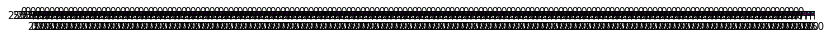

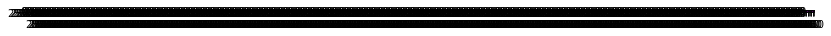

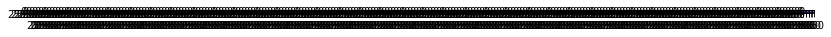

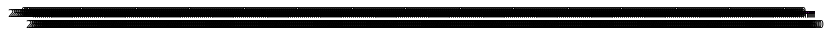

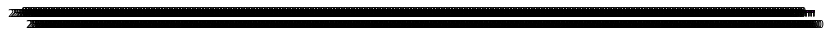

<Figure size 1008x720 with 0 Axes>

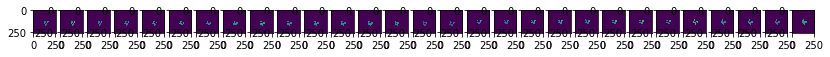

In [18]:
"Testing the new filter  - all areas should be the same, for one"

# the first function should probably produce the output for the 3rd slot in my thresholding function

# get and print areas, AND print test frames
for i in range(0, len(framesets)):
    i_props = transparent_threshold_properties(framesets[i])
    print(framesetnames[i] + " areas : ", [[i[0].area, i[1]] for i in i_props])
    fig, ax = plt.subplots(ncols=len(framesets[i]), figsize = (14, 10))
    for j in range(len(framesets[i])):
        ax[j].imshow(i_props[j][2])
print("\n\n")


In [19]:
"""Getting properties to separate frames by shape"""
properties = 
propnames= []
properties = [attrgetter(propname) for propname in propnames]

fig, ax = plt.subplots()
fig.set_title(propnames[i])
for i in range(0, len(framesets)):
    i_props = transparent_threshold_properties(framesets[i])
    y = [[i[0].inertia_tensor[0, 0] + i[0].inertia_tensor[1,1], i[1]] for i in i_props]
    x = [x[0] for x in y]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[i])
    #print(framesetnames[i] + " inertia tensors: ", y)    
#print("\n")


fig, ax = plt.subplots()
for i in range(0, len(framesets)):
    i_props = transparent_threshold_properties(framesets[i])
    y = [[i[0].major_axis_length, i[1]] for i in i_props]
    x = [x[0] for x in y]
    sns.distplot(x, hist = False, rug=True)
    #print(framesetnames[i] + " major_axis_lengths : ", y)
#print("\n")


fig, ax = plt.subplots()
for i in range(0, len(framesets)):
    i_props = transparent_threshold_properties(framesets[i])
    y = [[i[0].convex_area, i[1]] for i in i_props]
    x = [x[0] for x in y]
    sns.distplot(x, hist = False, rug=True)
    #print(framesetnames[i] + " convex_area : ", y)
#print("\n")
fig, ax = plt.subplots()
for i in range(0, len(framesets)):
    i_props = transparent_threshold_properties(framesets[i])
    y = [[i[0].solidity, i[1]] for i in i_props]
    x = [x[0] for x in y]
    sns.distplot(x, hist = False, rug=True)
    #print(framesetnames[i] + " solidity : ", y)
print("\n")
fig, ax = plt.subplots()
for i in range(0, len(framesets)):
    i_props = transparent_threshold_properties(framesets[i])
    y = [[i[0].inertia_tensor[0,0] / i[0].eccentricity, i[1]] for i in i_props]
    x = [x[0] for x in y]
    sns.distplot(x, hist = False, rug=True)
    #print(framesetnames[i] + " i/e : ", y)
#print("\n")


# don't use: extent, perimeter, minor axis lengths, solidity, eccetricity
# inertia: 300 - 360 br/bl, 350 - 415 tr/tl, 417/412 - bm
# mal: 56 - 63 br/bl, 63 - 70 tr/tl, 68 bm
# ecc: .63 - .78 br/bl, .76 - .83 tr/tl, .76 bm

# if solidity <= .76 and inertia > 400 => bm
# elif inertia >=355 and mal >= 63 => tl/tr
# elif inertia <= 355 and mal <= 63 => bl/br
# else unclassifiable



SyntaxError: invalid syntax (<ipython-input-19-2ef9f14289c5>, line 2)

In [20]:
"""FRAMES THAT WERE EXCLUDED WRONGLY, AD SOME THAT WERE EXCLUDED RIGHTLY, WITH THISE PREVIOUSLY EXCLUDED RIGHTLY"""

we_frames = {"b_r" : []22834, "broken" : [11130, 11578, 12062, 24673, 26394, 
                                                                           26387, 17288, 21377, 16725],
                  "t_r" : [11918, 12635, 17711, 17579], "t_l" : [16719, 17292, 17289, 17248, 17249],
                  "b_m" : [12133, 18009], "odd_s" : [17271, 16766, 16757, 16333, 15674,15666, 11990, 11973, 11658],
                  "b_l" : [22093, 23813, 26389, 26390, 26391, 26380, 26381, 26388, 26393, 26379, 26383]}

b_r_frames = [[green[trigger_frame - x], x] for x in phantom_frames.get("b_r")]
b_l_frames = [[green[trigger_frame - x], x] for x in phantom_frames.get("b_l")]
t_r_frames = [[green[trigger_frame - x], x] for x in phantom_frames.get("t_r")]
t_l_frames = [[green[trigger_frame - x], x] for x in phantom_frames.get("t_l")]
b_m_frames = [[green[trigger_frame - x], x] for x in phantom_frames.get("b_m")]



framesets = [b_r_frames, b_l_frames, t_r_frames, t_l_frames, b_m_frames]
framesetnames = ["b_r", "b_l", "t_r", "t_l", "b_m"]

SyntaxError: invalid syntax (<ipython-input-20-dec53d17f916>, line 3)

In [ ]:
"""Separating the frames which are similar otherwise by use of coordinate systems"""

In [21]:
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)

#functon to xor the results of both filters, and return the transparent dot
def get_transparent_dot(framelist):
    ones = []
    for framepair in framelist:
        frame = framepair[0] 
        i_threshed  = frame > threshold_isodata(frame)
        y_threshed  = frame > threshold_yen(frame)
        full = largest_region_extractor(measure.label(y_threshed))
        four = largest_region_extractor(measure.label(i_threshed))
        one_and_some = full^four
        ones.append(largest_region_extractor(measure.label(one_and_some)))
        
        
        """fig, ax = plt.subplots(ncols = 2)
        ax[0].imshow(one_and_some)
        ax[1].imshow(one)
        #print(one_and_some)
        #print(one)
        plt.show()"""
        
    return ones # A LIST WITH, FOR EACH FRAME, 
                # AN ARRAY OF TRUE/FALSE VALUES FOR EVERY PIXEL, CONTAINIGN THE LOCATION OF THE TRANSPARENT SPHERE


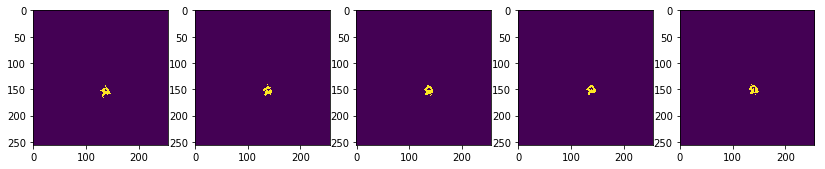

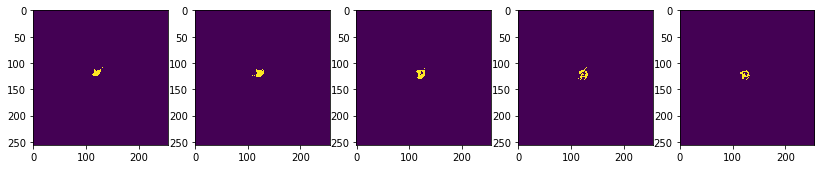

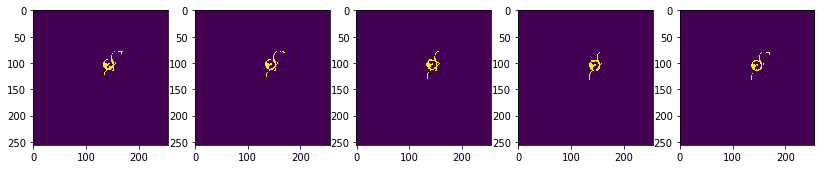

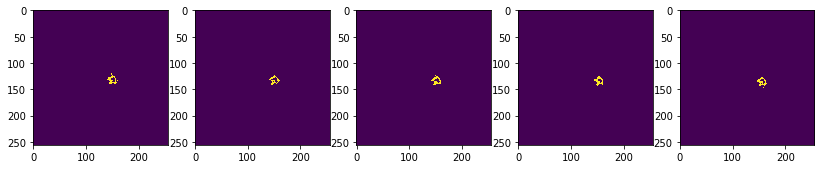

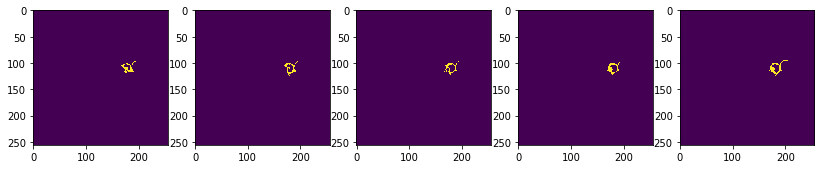

<Figure size 1008x720 with 0 Axes>

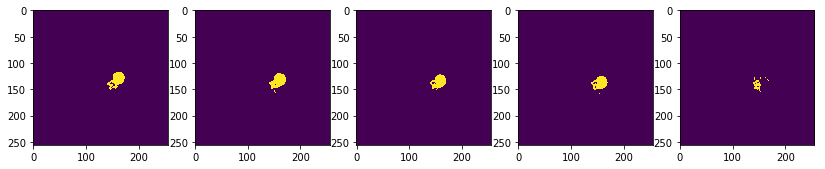

In [24]:

# get and print areas, AND print test frames
for i in range(0, len(framesets)):
    ones = get_transparent_dot(framesets[i][0:5])
    fig, ax = plt.subplots(ncols=len(framesets[i][0:5]), figsize = (14, 10))
    for j in range(len(framesets[i][0:5])):
        ax[j].imshow(ones[j])
print("\n\n")

In [ ]:
"Return the location of the transparent dot, relative to the major and minor axes of the image"
# get coordinate axis of four shapes

# get coordinates of com of transparent dot

#return what quadrant the tranparent dot is n relative to the 4particle axes

#return if com of transparent dot is in quadrant 1/3 or 2/4 (to distinguish )